In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import modules.shopee_model as ShopeeModel
import modules.model as Model
import modules.deep_model as DeepModel
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

## Công việc 3:
* Ở phần này chúng ta sẽ kết hợp **Emoji sentiment model** và **Comment sentiment model** lại thành một model duy nhất.
* Tiếp theo ta sẽ cho chúng dự đoán lại trên test data để xem khi kết hợp lại với nhau thì tổ hợp nào cho kết quả tốt nhất.
* Sau đó ta sẽ cho các tổ hợp model này dự đoán trên khoảng 10 comment mà ta sẽ lên trang chủ Shopee lấy về.

Đọc dữ liệu test lên.

In [4]:
X_test, y_test = Model.loadData("./data/emoji_data/test")
X_test = X_test.fillna("")

display(X_test, y_test)

,raw_comment,normalize_comment,emoji_decode
0,"Ui thực sự mê li luôn á,vải đẹp thự...",ui thực sự mê li luôn á vải đẹp thự...,smiling_face_with_three_hearts
1,"Vợt sale khá rẻ, chất lượng tiền na...",vợt sale khá rẻ chất lượng tiền nà...,satisfied satisfied satisfied satisfied
2,"Mua ao cho chong, Áo đẹp, chất vãi vừa ...",mua ao cho chong áo đẹp chất vãi vừa đu...,call_me_hand
3,Mình nhận được hàng đeo vào thử thì...,nhận được hàng đeo vào thử đứt ngan...,slightly_smiling_face
4,Vòng khá là ok nhé 😌😌😌😌😌😌😌😌😌😌😌\nGiao hàng...,vòng khá là ok nhé giao hàng hơi lâu,relieved relieved relieved relieved relieved r...
...,...,...,...
253,Tạm ổn ko có keo dán giao hàng lâu nử...,tạm ổn không có keo dán giao hàng lâu ...,sweat sweat sweat sweat
254,Túi xinh lắm lắm luôn ạ>< màu đen sang...,túi xinh lắm lắm luôn màu đen sang chả...,hand_over_mouth female_sign ok_person crying_c...
255,không biết là chất liệu len mới mua ...,không biết là chất liệu len mới mua ...,blush blush
256,Thực sự thì áo cũng ok vãi cũng ok nh...,thực sự áo cũng ok vãi cũng ok nhưng ...,relieved


,label
0,1
1,1
2,1
3,0
4,0
...,...
253,0
254,1
255,1
256,0


Bây giờ ta sẽ load tất cả các **Emoji sentiment model** và **Comment sentiment model** lên.

In [5]:
emoji_models = {}
emoji_models['logistic'] = Model.loadByPickle("./models/logistic_model_emojis.pickle")
emoji_models['svc'] = Model.loadByPickle("./models/svc_model_emojis.pickle")
emoji_models['rdforest'] = Model.loadByPickle("./models/rdforest_model_emojis.pickle")

In [6]:
comment_models = {}
comment_models['bernoulli'] = Model.loadByPickle("./models/bernoulli_model_comments.pickle")
comment_models['logistic'] = Model.loadByPickle("./models/logistic_model_comments.pickle")
comment_models['svc'] = Model.loadByPickle("./models/svc_model_comments.pickle")
comment_models['lstm_1'] = DeepModel.SentimentLSTM("./models/lstm_model_comments_1/lstm_model_comments_1.h5", 
                                                   "./models/lstm_model_comments_1/lstm_tokenizer_comments_1.pickle")
comment_models['lstm_uw_2'] = DeepModel.SentimentLSTM("./models/lstm_model_comments_2/lstm_model_comments_uw_2.h5", 
                                                      "./models/lstm_model_comments_2/lstm_tokenizer_comments_uw_2.pickle")

Tiến hành ghép cặp từng **Emoji sentiment model** và **Comment sentiment model**. Ta có ba emoji sentiment model và 5 comment sentiment model, vậy tổng cộng ta có 15 model tổ hợp như vậy.

In [7]:
shopee_sentiments = {}

for em in emoji_models.keys():
    for cm in comment_models.keys():
        shopee_sentiments[em + "_" + cm] = ShopeeModel.ShopeeSentiment(emoji_models[em], comment_models[cm])

Tiến hành kiểm tra một vài tổ hợp model trên test data để xem khi kết hợp hệ thống của chúng ta có chạy không. 

In [8]:
display(shopee_sentiments['logistic_lstm_1'].predict(X_test['raw_comment']),
        shopee_sentiments['logistic_bernoulli'].predict(X_test['raw_comment']))

9/9 [==============================] - 0s 17ms/step


,raw_review,probability,class
0,"Ui thực sự mê li luôn á,vải đẹp thự...","(0.021493457466946864, 0.9785065199703086)",1
1,"Vợt sale khá rẻ, chất lượng tiền na...","(0.07227157273331436, 0.9277284051186707)",1
2,"Mua ao cho chong, Áo đẹp, chất vãi vừa ...","(0.17741915287354187, 0.8225808648215871)",1
3,Mình nhận được hàng đeo vào thử thì...,"(0.930401839433207, 0.06959817829466373)",0
4,Vòng khá là ok nhé 😌😌😌😌😌😌😌😌😌😌😌\nGiao hàng...,"(0.428211670564817, 0.5717883170951589)",1
...,...,...,...
253,Tạm ổn ko có keo dán giao hàng lâu nử...,"(0.894638032498658, 0.10536194135336922)",0
254,Túi xinh lắm lắm luôn ạ>< màu đen sang...,"(0.15356041959373162, 0.8464396215008769)",1
255,không biết là chất liệu len mới mua ...,"(0.556766223051322, 0.4432337590789262)",0
256,Thực sự thì áo cũng ok vãi cũng ok nh...,"(0.8213207909747207, 0.1786792136382364)",0


,raw_review,probability,class
0,"Ui thực sự mê li luôn á,vải đẹp thự...","(0.07602110723294779, 0.9239788927670509)",1
1,"Vợt sale khá rẻ, chất lượng tiền na...","(0.5711369264586976, 0.4288630735413018)",0
2,"Mua ao cho chong, Áo đẹp, chất vãi vừa ...","(0.17708370502907242, 0.8229162949709279)",1
3,Mình nhận được hàng đeo vào thử thì...,"(0.9304587560061712, 0.06954124399382787)",0
4,Vòng khá là ok nhé 😌😌😌😌😌😌😌😌😌😌😌\nGiao hàng...,"(0.4373200880445736, 0.5626799119554267)",1
...,...,...,...
253,Tạm ổn ko có keo dán giao hàng lâu nử...,"(0.8900554562422651, 0.10994454375773455)",0
254,Túi xinh lắm lắm luôn ạ>< màu đen sang...,"(0.6488487269293757, 0.35115127307061744)",0
255,không biết là chất liệu len mới mua ...,"(0.5567335276186717, 0.443266472381325)",0
256,Thực sự thì áo cũng ok vãi cũng ok nh...,"(0.8180279652550244, 0.18197203474497237)",0


Ở đây câu hỏi đặt ra là làm sao chúng ta có thể kết hợp kết quả từ hai model.

Giả sử nếu các model của chúng ta dự đoán ra kết quả là 0 và 1, thì với hai model ta sẽ gặp khó khăn trong trường hợp:
  * Emoji sentiment model dự đoán 0 và Comment sentiment model dự đoán 1.
  * Emoji sentiment model dự đoán 1 và Comment sentiment model dự đoán 0.
  Khi rơi vào những trường hợp này, ta khó lòng chọn đâu là kết quả phù hợp. Nên ở đây thường người ta sẽ đào tạo 3 model và cho chúng votting. Với RandomForest nó cũng làm điều này nhưng sklearn sử dụng kĩ thuật là BaggingVotting.

Một cách mà nhóm dùng để xử lí vấn đề này là nhóm sẽ cho toàn bộ các model trả về giá trị xác suất, đó là lí do mà các model Deep Learning sử dụng activation là **softmax** thay vì **sigmoid**. Ở sklearn thì ngoại trừ các model SVC ta phải bật cờ `probability=True` thì toàn bộ các classifier khác đều hỗ trợ dự đoán xác suất, lúc này ta đơn giản lấy trung bình cộng giữa các class tương ứng giữa **Emoji sentiment model** và **Comment sentiment model** so sánh xem xác suất nào lớn hơn thì review này thuộc vào nhóm đó.

Trong trường hợp review chỉ có mỗi emoji hoặc comment, ta xử lí còn dễ dàng hơn là chỉ sử dụng model tương ứng để dự đoán.

Bây giờ ta sẽ cho 15 tổ hợp model này dự đoán lại trên test data sau đó đánh giá accuracy.

In [9]:
models_acc = []
for model_name, model in shopee_sentiments.items():
    y_pred = model.predict(X_test['raw_comment'])
    acc = accuracy_score(y_test, y_pred['class'])
    models_acc.append((model_name, acc))
models_acc = np.array(models_acc)

print(models_acc)

9/9 [==============================] - 0s 8ms/step
[['logistic_bernoulli' '0.9108527131782945']
 ['logistic_logistic' '0.9224806201550387']
 ['logistic_svc' '0.9263565891472868']
 ['logistic_lstm_1' '0.9534883720930233']
 ['logistic_lstm_uw_2' '0.9263565891472868']
 ['svc_bernoulli' '0.9147286821705426']
 ['svc_logistic' '0.8953488372093024']
 ['svc_svc' '0.8992248062015504']
 ['svc_lstm_1' '0.9534883720930233']
 ['svc_lstm_uw_2' '0.9302325581395349']
 ['rdforest_bernoulli' '0.9147286821705426']
 ['rdforest_logistic' '0.9224806201550387']
 ['rdforest_svc' '0.9302325581395349']
 ['rdforest_lstm_1' '0.9534883720930233']
 ['rdforest_lstm_uw_2' '0.9302325581395349']]


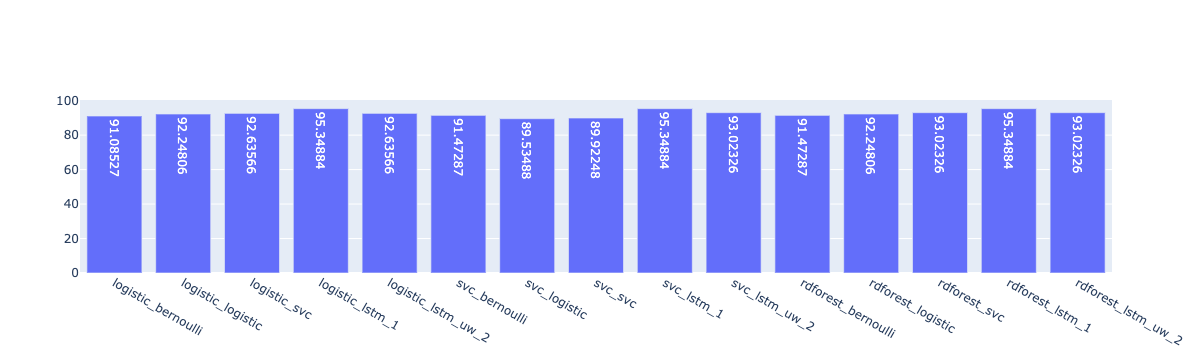

In [10]:
ShopeeModel.accBarChart(models_acc)

> **Nhận xét**:
> * Ở đây sau khi kết  hợp lại thì có 13 model cho accuracy trên 85%.
> * 6 model cho accuracy hơn 90%. - và các model này đều có **comment sentiment model** sử dụng LSTM.
> * Một điều thú vị là ở những bước trước ta đánh giá **Emoji sentiment model** dùng RandomForest bị overfitting nhưng khi kết hợp với LSTM model thì nó cho ra accuracy cao nhất lên đến 93%. Rõ ràng một điều là ta không thể biết trước được điều gì hay khẳng định chắc chắn được điều này trên dữ liệu của chúng ta.

Bây giờ ta sẽ đi lấy 10 review ngẫu nhiên trên Shopee và cho các model dự đoán trên các review mới này. Năm review đầu tiên được lấy từ các review có 4 và 5 sao, 5 review cuối cùng được lấy từ các review có từ 3 sao trở xuống.

In [11]:
new_reviews = pd.DataFrame()
new_reviews['review'] = [
    "áo đẹp. bố mình rất ưng và rất thíc nhé. lên mua nhé các bạn mình.😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝😝",
    "Áo khá ấm, vải mềm, không có chỉ thừa, tuy nhiên khi giặt thì có hơi nhiều phấn vải",
    "Áo nỉ khá dày, nhẹ tênh, giống hình, thời gian giao hàng nhanh!ok, còn đc tặng voucher xịn xò!!!!!!!",
    "Chất ổn nhưng dây quần như bị ố nhìn khá xấu. Về tổng quan thì ổn 👍",
    "Mỏng, chất dễ xù, ban đầu thấy chất khá cứng, nhưng form vẫn chấp nhận dc",
    "Giao màu khác trong ảnh. Nhìn già kinh luôn. Các b cẩn thận khi mua. Màu nó là màu nâu sẫm chứ k giống trong ảnh chút nào :))) Cho bố e, bố e còn k thèm thì đủ hiểu nó già ntn :)))",
    "Lười chẳng buồn chụp cái áo vì thất vọng toàn tập, áo màu chuẩn giống hình nhưng len nhão, rộng khủng khiếp, cổ trễ quá sâu, phần nách thì k hề ôm vào ng mà cứ bửa hết ra khả năng là may lỗi, sẽ k dám mua quần áo qua mạng nữa",
    "Áo màu k giống ảnh phần viền là màu nâu đậm thêm nữa cổ áo rất rộng 🙂🙂",
    "Áo khác trên ảnh nhiều lắm 🙂màu nhạt dã man xong cổ rộng tóm lại k đáng tiền",
    "Áo rộng thùng thình bố mình mặc còn vừa nên mình cho bố  luôn rồi. Màu áo ship về cũng không được đẹp cho lắm.Nói chung là hơi thất vọng."
]

In [12]:
for model_name, model in shopee_sentiments.items():
    new_reviews[model_name] = model.predict(new_reviews['review'])['class']
    
new_reviews.transpose()

1/1 [==============================] - 0s 21ms/step


,0,1,2,3,4,5,6,7,8,9
review,áo đẹp. bố mình rất ưng và rất thíc nhé. lên m...,"Áo khá ấm, vải mềm, không có chỉ thừa, tuy nhi...","Áo nỉ khá dày, nhẹ tênh, giống hình, thời gian...",Chất ổn nhưng dây quần như bị ố nhìn khá xấu. ...,"Mỏng, chất dễ xù, ban đầu thấy chất khá cứng, ...",Giao màu khác trong ảnh. Nhìn già kinh luôn. C...,Lười chẳng buồn chụp cái áo vì thất vọng toàn ...,Áo màu k giống ảnh phần viền là màu nâu đậm th...,Áo khác trên ảnh nhiều lắm 🙂màu nhạt dã man xo...,Áo rộng thùng thình bố mình mặc còn vừa nên mì...
logistic_bernoulli,1,0,1,0,0,0,0,0,0,0
logistic_logistic,1,1,1,1,0,0,0,0,0,0
logistic_svc,1,1,1,1,0,0,0,0,0,0
logistic_lstm_1,1,1,1,1,0,0,0,0,0,0
logistic_lstm_uw_2,1,1,1,1,0,0,0,0,0,0
svc_bernoulli,1,0,1,0,0,0,0,0,0,0
svc_logistic,1,1,1,1,0,0,0,0,0,0
svc_svc,1,1,1,1,0,0,0,0,0,0
svc_lstm_1,1,1,1,0,0,0,0,0,0,0


> **Nhận xét**:
> * Có thể thấy toàn bộ các model có **Comment sentiment model** sử dụng `lstm_1` đều cho ra kết quả chính xác. Các model sử dụng các tradional classifier ở **Comment sentiment model** dự đoán còn sai nhiều ở các comment positive nhưng lại nhầm sang negative.
> * Từ đây, có thể cho ra kết quả như sau, đối vối Shopee review dataset của chúng ta, nếu xét riêng về phần comment thì các model Deep Learning hoạt động tốt hơn hẳn, điều này có lẽ vì do việc cấu trúc của comment ảnh hưởng lớn đến kết quả phân lớp.
> * Trong 15 model, các model có phần **comment sentiment model** sử dụng `lstm_1` cho ra kết quả tốt, ta có thể giữ lại và cải thiện hoặc phát triển về sau.

# Tài liệu tham khảo:
* [Hands-On Deep Learning Algorithms with Python](https://www.packtpub.com/product/hands-on-deep-learning-algorithms-with-python/9781789344158)
* [Keras Deep Learning Cookbook](https://www.amazon.com/Keras-Deep-Learning-Cookbook-implementing/dp/1788621751)
* [Applied Text Analysis with Python](https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/)
* [Deep Learning Quick Reference](https://www.packtpub.com/product/deep-learning-quick-reference/9781788837996)
* [Advanced Natural Language Processing with TensorFlow 2](https://www.amazon.com/Advanced-Natural-Language-Processing-TensorFlow/dp/1800200935)
* [Natural Language Processing with TensorFlow](https://www.packtpub.com/product/natural-language-processing-with-tensorflow/9781788478311)
* Và một số tài liệu, bài viết trên các trang GeekForGeeks, Medium, TowardsDataScience, TensorFlow,...